# A simple model

Let's take a simplified version of the model described in the text, one with atmospheric, terrestrial and ocean carbon. 

| Reservoir   | Initial amount (Gt) |
|-------------|---------------------|
| Atmosphere  | 750                 |
| Terrestrial | 600                 |
| Ocean       | 1000                |

And let's use the following major fluxes:

| Flux                            | Rate (Gt C/yr) | Source      | Sink        |
|---------------------------------|----------------|-------------|-------------|
| Terrestrial Photosynthesis      | 110            | Atmosphere  | Terrestrial |
| Marine Photosynthesis           | 40             | Atmosphere  | Ocean       |
| People dumping trash into ocean | 110            | Terrestrial | Ocean       |
| Marine Respiration              | 150            | Ocean       | Atmosphere  |

With that in mind, we could make a completely stable, unchanging model

In [1]:
import numpy as np, matplotlib as mpl, pandas as pd, seaborn as sns
from matplotlib import pyplot as plt
from scipy import integrate
from ipywidgets import interact, fixed

%matplotlib inline

/Users/mglerner/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


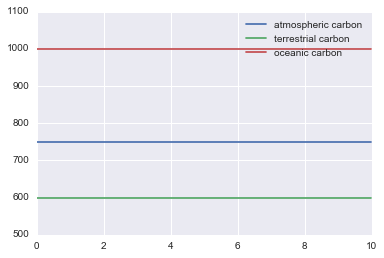

In [2]:
atmos, terrestrial, ocean = 750, 600, 1000
a_t, a_o, t_o, o_a = 110, 40, 110, 150

time = 0
dt = 0.01

def evolve_system(time,dt,atmos,terrestrial,ocean,a_t,a_o,t_o,o_a):
    atmos, terrestrial, ocean = atmos - a_t - a_o + o_a, terrestrial - t_o + a_t, ocean - o_a + a_o + t_o
    return atmos, terrestrial, ocean

system_state = []
for step in range(1000):
    time = time + dt
    atmos, terrestrial, ocean = evolve_system(time,dt,atmos,terrestrial,ocean,a_t, a_o, t_o, o_a)
    system_state.append((time,atmos,terrestrial,ocean))

time = [i[0] for i in system_state]
atmos = [i[1] for i in system_state]
terrestrial = [i[2] for i in system_state]
ocean = [i[3] for i in system_state]

plt.plot(time,atmos,label='atmospheric carbon')
plt.plot(time,terrestrial,label='terrestrial carbon')
plt.plot(time,ocean,label='oceanic carbon')
plt.ylim([500,1100])
plt.legend()

So, not very exciting. But that's because we're doing it wrong. The rates given above are *initial* rates. You should recall from the reading (and from your own thought process) that the rate of carbon flow from, e.g., the atmosphere to the ocean depends on how much carbon is in the atmosphere to begin with. If there's more carbon in the atmosphere, more carbon will flow to the ocean. That is, you might imagine that more Gt of carbon will flow to from the atmosphere to the ocean if we have 70000 Gt of carbon in the atmosphere than if we have 20 Gt C.

Let's put this back into the language of mathematics. The model we plotted above looks like

$\frac{dA}{dt} = -110 - 40 + 150\\
\frac{dT}{dt} = -100 + 110\\
\frac{dO}{dt} = -150 + 40 + 110
$

Followed by a simple update

$A_{i+1} = A_{i} + \Delta t * \frac{dA}{dt}\\
...
$

Those rates are constant. But, as we just discussed, we really want those rates to depend on the amount of carbon in the various reservoirs. You might also get a clue that it's wrong because my above code didn't actually care what $\Delta t$ was.

So, if we want our model to care about flow between the reservoirs properly, let's think about those rates. Instead of saying `terrestrial photosynthesis = 110` let's say `terrestrial photosynthesis = terrestrial_carbon * terrestrial_photosynthesis_rate`, etc. Then our model might look like (recalling our tables):

| Reservoir   | Initial amount (Gt) |
|-------------|---------------------|
| Atmosphere  | 750                 |
| Terrestrial | 600                 |
| Ocean       | 1000                |

And let's use the following major fluxes:

| Flux                            | Rate (Gt C/yr) | Source      | Sink        |
|---------------------------------|----------------|-------------|-------------|
| Terrestrial Photosynthesis      | 110            | Atmosphere  | Terrestrial |
| Marine Photosynthesis           | 40             | Atmosphere  | Ocean       |
| People dumping trash into ocean | 110            | Terrestrial | Ocean       |
| Marine Respiration              | 150            | Ocean       | Atmosphere  |


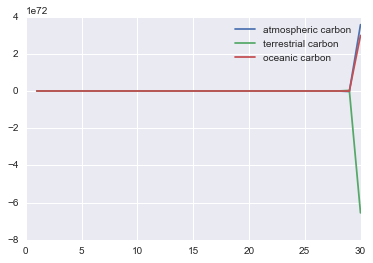

In [3]:
atmos, terrestrial, ocean = 750, 600, 1000
a_t_rate, a_o_rate, t_o_rate, o_a_rate = 110/750, 40/750, 110/600, 150/1000

time = 0
dt = 1 # This is in years, based on what I've done above. You want dt in something smaller than years. How do you handle that?

def evolve_system(dt,atmos,terrestrial,ocean,a_t_rate,a_o_rate,t_o_rate,o_a_rate):
    a_t = a_t_rate * atmos * dt
    a_o = a_o_rate * atmos * dt
    t_o = t_o_rate * terrestrial * dt
    o_a = o_a_rate * ocean * dt
    atmos, terrestrial, ocean = atmos - a_t - a_o + o_a, terrestrial - t_o + a_t, ocean - o_a + a_o + t_o
    return atmos, terrestrial, ocean

system_state = []
for step in range(30):
    time = time + dt
    atmos, terrestrial, ocean = evolve_system(dt,atmos,terrestrial,ocean,a_t, a_o, t_o, o_a)
    system_state.append((time,atmos,terrestrial,ocean))

time = [i[0] for i in system_state]
atmos = [i[1] for i in system_state]
terrestrial = [i[2] for i in system_state]
ocean = [i[3] for i in system_state]

plt.plot(time,atmos,label='atmospheric carbon')
plt.plot(time,terrestrial,label='terrestrial carbon')
plt.plot(time,ocean,label='oceanic carbon')
#plt.ylim([500,1100])
plt.legend()

Now, as you can see above, things are certainly not constant. Part of the problem is that you have a horribly long timestep. Part of the problem is that you're using a crummy integrator. Here's what happens for me when I fix the timestep:

In [4]:
def plotit(dt):
    atmos, terrestrial, ocean = 750, 600, 1000
    a_t_rate, a_o_rate, t_o_rate, o_a_rate = dt*0.147, dt*0.053, dt*0.183, dt*0.15

    time = 0

    def evolve_system(dt,atmos,terrestrial,ocean,a_t_rate,a_o_rate,t_o_rate,o_a_rate):
        a_t = a_t_rate * atmos * dt
        a_o = a_o_rate * atmos * dt
        t_o = t_o_rate * terrestrial * dt
        o_a = o_a_rate * ocean * dt
        atmos, terrestrial, ocean = atmos - a_t - a_o + o_a, terrestrial - t_o + a_t, ocean - o_a + a_o + t_o
        return atmos, terrestrial, ocean

    system_state = []
    for step in range(300):
        time = time + dt
        atmos, terrestrial, ocean = evolve_system(dt,atmos,terrestrial,ocean,a_t, a_o, t_o, o_a)
        system_state.append((time,atmos,terrestrial,ocean))

    time = [i[0] for i in system_state]
    atmos = [i[1] for i in system_state]
    terrestrial = [i[2] for i in system_state]
    ocean = [i[3] for i in system_state]

    plt.plot(time,atmos,label='atmospheric carbon')
    plt.plot(time,terrestrial,label='terrestrial carbon')
    plt.plot(time,ocean,label='oceanic carbon')
    #plt.ylim([500,1100])
    plt.legend()

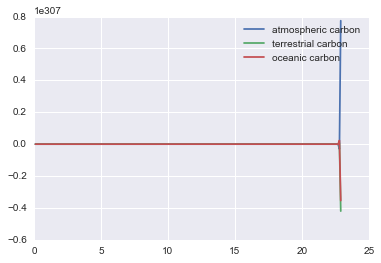

In [5]:
plotit(dt=.1)

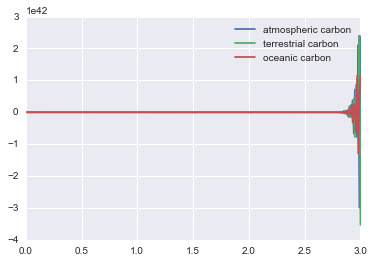

In [6]:
plotit(dt=.01)

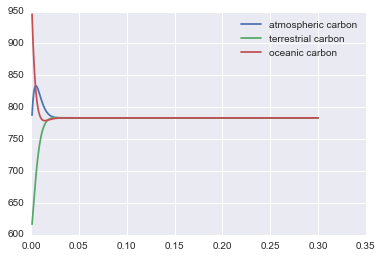

In [7]:
plotit(dt=.001)

So, that should give you enough to get started. Remember, your model is more complex than the one above. So, hopefully, it has a more interesting final behavior.

Don't forget to try to find a way to use a better integrator. You can feel free to use one of the functions from `scipy` or to google for Runge-Kutta 4 in Python.

Also don't forget the sentence "Assume that the rate of change of marine materials sinking to the deep ocean is constant, but in all other cases, assume that the rate of car- bon transfer from source to sink is proportional to the amount of carbon in the source."


 (B. 254)

B., Shiflet, A., Shiflet, W.. Introduction to Computational Science: Modeling and Simulation for the Sciences,  2nd Edition. Princeton University Press, 03/2014. VitalBook file.


In [8]:
def plotit_full(dt,nsteps):
    atmos, terrestrial, ocean_surface, deep_ocean, soil = 750, 600, 800, 38000, 1500
    a_t_rate = dt * 110/atmos
    a_os_rate = dt * 40/atmos
    t_a_rate = dt * 55/terrestrial
    os_a_rate = dt * 40/ocean_surface
    a_os_rate2 = dt * 100/atmos
    os_a_rate2 = dt * 100/ocean_surface
    do_os_rate = dt * 27/deep_ocean
    os_do_rate = dt * 23/ocean_surface # stays constant
    os_do_rate2 = dt * 4/ocean_surface
    t_s_rate = dt * 55/terrestrial
    s_a_rate = dt * 55/soil
    

    time = 0

    def evolve_system(dt,atmos,terrestrial,ocean_surface,deep_ocean,soil):
        a_t = a_t_rate * dt * atmos
        a_os = a_os_rate * dt * atmos
        t_a = t_a_rate * dt * terrestrial
        os_a = os_a_rate * dt * ocean_surface
        a_os2 = a_os_rate2 * dt * atmos
        os_a2 = os_a_rate2 * dt * ocean_surface
        do_os = do_os_rate * dt * deep_ocean
        os_do =  23*dt #os_do_rate * dt * ocean_surface # stays constant 23*dt #
        os_do2 = os_do_rate2 * dt * ocean_surface
        t_s = t_s_rate * dt * terrestrial
        s_a = s_a_rate * dt * soil
        atmos, terrestrial, ocean_surface, deep_ocean, soil = (atmos - a_t - a_os - a_os2 + t_a + os_a + os_a2 + s_a,
                                                               terrestrial - t_a - t_s + a_t,
                                                               ocean_surface - os_a - os_a2 - os_do - os_do2 + a_os + a_os2 + do_os,
                                                               deep_ocean - do_os + os_do + os_do2,
                                                               soil - s_a + t_s)
        atmos = max(atmos,0)
        terrestrial = max(terrestrial,0)
        ocean_surface = max(ocean_surface,0)
        deep_ocean = max(deep_ocean,0)
        soil = max(soil,0)
        return atmos,terrestrial,ocean_surface,deep_ocean,soil

    system_state = []
    for step in range(nsteps):
        time = time + dt
        atmos,terrestrial,ocean_surface,deep_ocean,soil = evolve_system(dt,atmos,terrestrial,ocean_surface,deep_ocean,soil)
        system_state.append((time,atmos,terrestrial,ocean_surface,deep_ocean,soil))

    time = [i[0] for i in system_state]
    atmos = [i[1] for i in system_state]
    terrestrial = [i[2] for i in system_state]
    ocean_surface = [i[3] for i in system_state]
    deep_ocean = [i[4] for i in system_state]
    soil = [i[5] for i in system_state]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    
    ax2.plot(time,atmos,label='atmosphere')
    ax2.plot(time,terrestrial,label='terrestrial')
    ax2.plot(time,ocean_surface,label='oceanic surface')
    ax1.plot(time,deep_ocean,label='deep ocean')
    ax2.plot(time,soil,label='soil')
    ax1.plot(time,np.array(atmos) + np.array(terrestrial) + np.array(ocean_surface) + np.array(deep_ocean) + np.array(soil),'k--',label='net')
    #plt.ylim([500,1100])
    plt.legend()

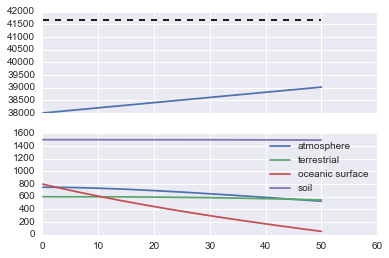

In [9]:
plotit_full(.1,500)

In [10]:
def plotit_full(dt, nsteps):
    atmosphere, terrestrial, ocean_surface, deep_ocean, soil = 750, 600, 800, 38000, 1500
    a_t_rate = dt * 110 / atmosphere
    a_os_rate = dt * 40 / atmosphere
    t_a_rate = dt * 55 / terrestrial
    os_a_rate = dt * 40 / ocean_surface
    a_os_rate2 = dt * 100 / atmosphere
    os_a_rate2 = dt * 100 / ocean_surface
    do_os_rate = dt * 27 / deep_ocean
    os_do_rate = dt * 23 / ocean_surface
    os_do_rate2 = dt * 4 / ocean_surface
    t_s_rate = dt * 55 / terrestrial
    s_a_rate = dt * 55 / soil
    time = 0

    def evolve_system(dt, atmosphere, terrestrial, ocean_surface, deep_ocean, soil):
        a_t = a_t_rate * dt * atmosphere
        a_os = a_os_rate * dt * atmosphere
        t_a = t_a_rate * dt * terrestrial
        os_a = os_a_rate * dt * ocean_surface
        a_os2 = a_os_rate2 * dt * atmosphere #
        os_a2 = os_a_rate2 * dt * ocean_surface #
        do_os = do_os_rate * dt * deep_ocean
        os_do =  os_do_rate * dt * ocean_surface
        os_do2 = os_do_rate2 * dt # constant ; os_do_rate2 * dt * ocean_surface
        t_s = t_s_rate * dt * terrestrial
        s_a = s_a_rate * dt * soil

        if (atmosphere < ocean_surface):
            atmosphere = atmosphere - a_t - a_os + t_a + os_a + os_a2 + s_a
            ocean_surface = ocean_surface - os_a - os_a2 - os_do - os_do2 + a_os + do_os
        elif (atmosphere > ocean_surface):
            atmosphere = atmosphere - a_t - a_os - a_os2 + t_a + os_a + s_a
            ocean_surface = ocean_surface - os_a - os_do - os_do2 + a_os + a_os2 + do_os
        else:
            atmosphere = atmosphere - a_t - a_os + t_a + os_a + s_a
            ocean_surface = ocean_surface - os_a - os_do - os_do2 + a_os + do_os

        terrestrial = terrestrial - t_a - t_s + a_t
        deep_ocean = deep_ocean - do_os + os_do + os_do2
        soil = soil - s_a + t_s

        atmosphere = max(atmosphere, 0)
        terrestrial = max(terrestrial, 0)
        ocean_surface = max(ocean_surface, 0)
        deep_ocean = max(deep_ocean, 0)
        soil = max(soil, 0)

        return atmosphere, terrestrial, ocean_surface, deep_ocean, soil

    system_state = []
    for step in range(nsteps):
        time = time + dt
        atmosphere, terrestrial, ocean_surface, deep_ocean, soil = evolve_system(dt, atmosphere, terrestrial, ocean_surface, deep_ocean, soil)
        system_state.append((time, atmosphere, terrestrial, ocean_surface, deep_ocean, soil))

    time = [i[0] for i in system_state]
    atmosphere = [i[1] for i in system_state]
    terrestrial = [i[2] for i in system_state]
    ocean_surface = [i[3] for i in system_state]
    deep_ocean = [i[4] for i in system_state]
    soil = [i[5] for i in system_state]

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True,figsize=(12, 6))

    ax4.plot(time, atmosphere, label='atmosphere',color='deepskyblue')
    ax4.plot(time, terrestrial, label='terrestrial',color='green')
    ax4.plot(time, ocean_surface, label='oceanic surface',color='blue')
    ax2.plot(time, deep_ocean, label='deep ocean',color='darkblue')
    ax3.plot(time, soil, label='soil',color='peru')
    ax1.plot(time, np.array(atmosphere) + np.array(terrestrial) + np.array(ocean_surface) + np.array(deep_ocean) + np.array(soil),'k--',label='net')
    #plt.ylim([500,1100])
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()


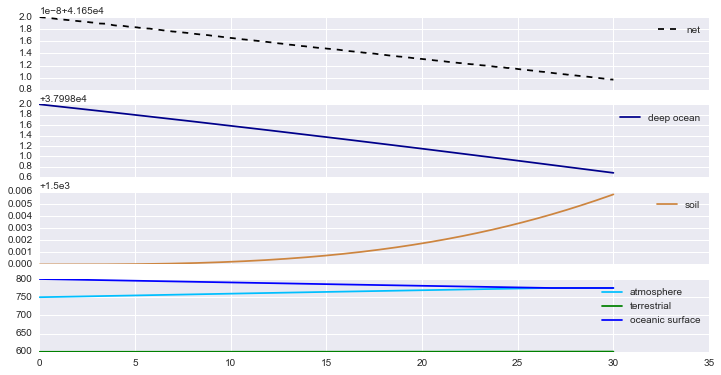

In [11]:
plotit_full(.01,3000)

# Using a real integrator

Let's use a real integrator. First, let's make sure we can reproduce Lotka-Volterra:

$
x' = a x - b x y\\
y' = - c y + d xy 
$

Let's let `X` be our variables, `x,y`. We'll define a function that returns the derivatives

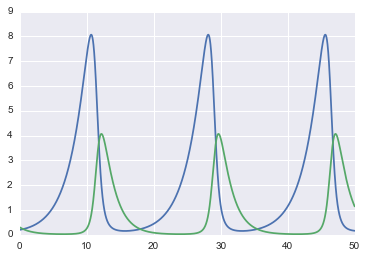

In [12]:
a,b,c,d = 0.4, 0.5, 0.6, 0.3
init = [.2,.3] # initial populations
def derivX(X,t):
    x,y = X
    return np.array([a*x - b*x*y,
                    -c*y + d*x*y])
time = np.linspace(0,50,10000)
from scipy import integrate
X = integrate.odeint(derivX,init,time)
fig,ax = plt.subplots(1,1)
ax.plot(time,X[:,0],label='thing1')
ax.plot(time,X[:,1],label='thing2')

/Users/mglerner/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


<function __main__.lv>

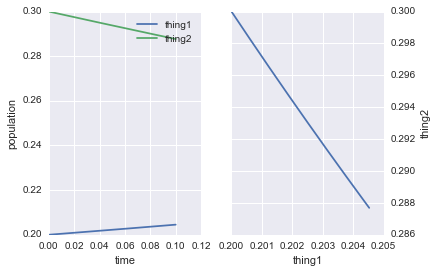

In [13]:

def lv(a=0.4,b=0.6,c=0.5,d=0.4,x0=0.2,y0=0.3,tf=0.1):
    def derivX(X,t):
        x,y = X
        return np.array([a*x - b*x*y,
                        -c*y + d*x*y])
    init = [x0,y0] # initial populations
    time = np.linspace(0,tf,100000)
    from scipy import integrate
    X = integrate.odeint(derivX,init,time)
    fig,(ax1,ax2) = plt.subplots(1,2)
    ax1.plot(time,X[:,0],label='thing1')
    ax1.plot(time,X[:,1],label='thing2')
    ax2.plot(X[:,0],X[:,1])
    ax1.set_xlabel('time')
    ax1.set_ylabel('population')
    ax2.set_xlabel('thing1')
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()

    ax2.set_ylabel('thing2')
    ax1.legend()
    ax2.legend()
from ipywidgets import interact
interact(lv,a=(0,1.0),b=(0,1.0),c=(0,1.0),d=(0,1.0),x0=(0,1.0),y0=(0,1.0),tf=(0.1,50,0.1))

# Our model

So, that works. Let's write ours out in the same way.

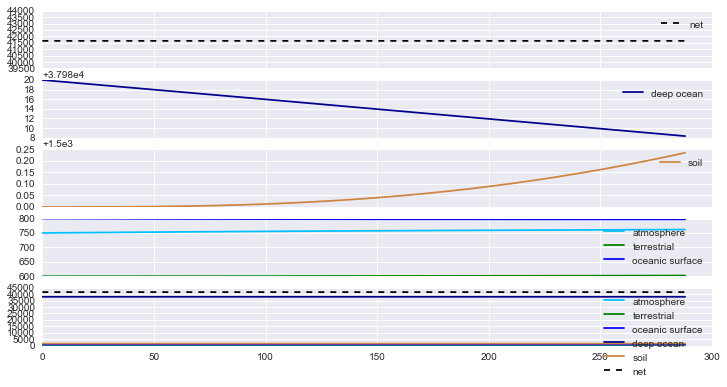

In [14]:
dt = 0.01
atmosphere, terrestrial, ocean_surface, deep_ocean, soil = 750, 600, 800, 38000, 1500

def cc(atmosphere0 = atmosphere,
       terrestrial0 = terrestrial,
       ocean_surface0 = ocean_surface,
       deep_ocean0 = deep_ocean,
       soil0 = soil,
       a_t_rate = dt * 110 / atmosphere,
       a_os_rate = dt * 40 / atmosphere, 
       t_a_rate = dt * 55 / terrestrial,
       os_a_rate = dt * 40 / ocean_surface,
       a_os_rate2 = dt * 100 / (atmosphere - ocean_surface),##
       os_a_rate2 = dt * 100 / ocean_surface,
       do_os_rate = dt * 27 / deep_ocean,
       os_do_rate = dt * 23 / ocean_surface,
       os_do_rate2 = dt * 4 / ocean_surface,
       t_s_rate = dt * 55 / terrestrial,
       s_a_rate = dt * 55 / soil,
       tf = 25.0,
      ):
    def derivX(X,t):
        atmosphere, terrestrial, ocean_surface, deep_ocean, soil = X
        
        a_t = a_t_rate * atmosphere
        a_os = a_os_rate * atmosphere
        t_a = t_a_rate * terrestrial
        os_a = os_a_rate * ocean_surface
        a_os_both = a_os_rate2 * atmosphere #
        ##os_a2 = os_a_rate2 * ocean_surface #
        do_os = do_os_rate * deep_ocean
        os_do =  os_do_rate * ocean_surface
        os_do2 = os_do_rate2 # constant ; os_do_rate2 * dt * ocean_surface
        t_s = t_s_rate * terrestrial
        s_a = s_a_rate * soil

        aos_both = a_os_rate2 * (atmosphere - ocean_surface)

        datmosphere =  - a_t - a_os + t_a + os_a + s_a - aos_both #+ os_a2
        docean_surface =  - os_a  - os_do - os_do2 + a_os + do_os + aos_both #- os_a2

        dterrestrial =  - t_a - t_s + a_t
        ddeep_ocean =  - do_os + os_do + os_do2
        dsoil =  - s_a + t_s

        #atmosphere = max(atmosphere, 0)
        #terrestrial = max(terrestrial, 0)
        #ocean_surface = max(ocean_surface, 0)
        #deep_ocean = max(deep_ocean, 0)
        #soil = max(soil, 0)
        
        return np.array([datmosphere, dterrestrial, docean_surface, ddeep_ocean, dsoil])

    init = [atmosphere0, terrestrial0, ocean_surface0, deep_ocean0, soil0] # initial populations
    time = np.arange(0,tf,dt)
    X = integrate.odeint(derivX,init,time)
    atmosphere, terrestrial, ocean_surface, deep_ocean, soil = X[:,0], X[:,1], X[:,2], X[:,3], X[:,4]
    net = atmosphere + terrestrial + ocean_surface + deep_ocean + soil

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True,figsize=(12, 6))
    
    ax4.plot(time, atmosphere, label='atmosphere',color='deepskyblue')
    ax4.plot(time, terrestrial, label='terrestrial',color='green')
    ax4.plot(time, ocean_surface, label='oceanic surface',color='blue')
    ax2.plot(time, deep_ocean, label='deep ocean',color='darkblue')
    ax3.plot(time, soil, label='soil',color='peru')
    ax1.plot(time, net,'k--',label='net')
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    
    ax5.plot(time, atmosphere, label='atmosphere',color='deepskyblue')
    ax5.plot(time, terrestrial, label='terrestrial',color='green')
    ax5.plot(time, ocean_surface, label='oceanic surface',color='blue')
    ax5.plot(time, deep_ocean, label='deep ocean',color='darkblue')
    ax5.plot(time, soil, label='soil',color='peru')
    ax5.plot(time, net,'k--',label='net')
    ax5.legend()
interact(cc,tf=(1,5000),
         a_t_rate = fixed(dt * 110 / atmosphere),
         a_os_rate = fixed(dt * 40 / atmosphere), 
         t_a_rate = fixed(dt * 55 / terrestrial),
         os_a_rate = fixed(dt * 40 / ocean_surface),
         a_os_rate2 = fixed(dt * 100 / atmosphere),
         os_a_rate2 = fixed(dt * 100 / ocean_surface),
         do_os_rate = fixed(dt * 27 / deep_ocean),
         os_do_rate = fixed(dt * 23 / ocean_surface),
         os_do_rate2 = fixed(dt * 4 / ocean_surface),
         t_s_rate = fixed(dt * 55 / terrestrial),
         s_a_rate = fixed(dt * 55 / soil),
        )

# Now project 2

## We'll need carrying capacity

So here's a basic logistic growth model

$ \frac{du}{dt} = a u (1 - \frac{u}{R}) \\
u_0 = A
$

where R is the max number of individuals

In [21]:
dt = 0.01
def logistic(a=1.0,R=100,A=1.0,tf=10):
    def f(u,t):
        u = u[0]
        return np.array([a*u*(1-u/R)])
    time = np.arange(0,tf,dt)
    X = integrate.odeint(f,[A],time)
    plt.plot(time,X[:,0])

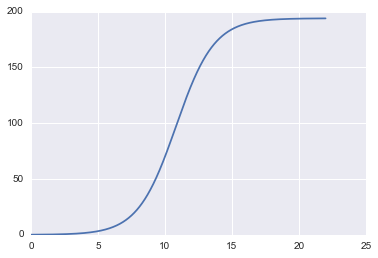

In [25]:
interact(logistic)

<function __main__.cc>

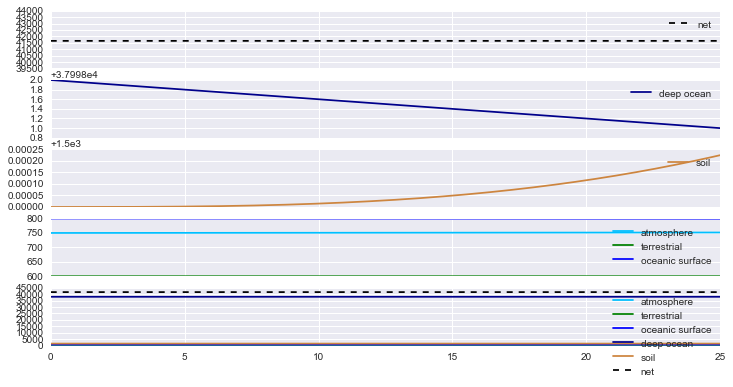

In [26]:
dt = 0.01
atmosphere, terrestrial, ocean_surface, deep_ocean, soil = 750, 600, 800, 38000, 1500
fossil_fuel_reservoir = 4000

def cc(atmosphere0 = atmosphere,
       terrestrial0 = terrestrial,
       ocean_surface0 = ocean_surface,
       deep_ocean0 = deep_ocean,
       soil0 = soil,
       a_t_rate = dt * 110 / atmosphere,
       a_os_rate = dt * 40 / atmosphere, 
       t_a_rate = dt * 55 / terrestrial,
       os_a_rate = dt * 40 / ocean_surface,
       a_os_rate2 = dt * 100 / (atmosphere - ocean_surface),##
       do_os_rate = dt * 27 / deep_ocean,
       os_do_rate = dt * 23 / ocean_surface,
       os_do_rate2 = dt * 4 / ocean_surface,
       t_s_rate = dt * 55 / terrestrial,
       s_a_rate = dt * 55 / soil,
       combustion_rate = dt * 5 / fossil_fuel_reservoir
       deforestation_rate = dt * 1.15 /
       tf = 25.0,
      ):
    def derivX(X,t):
        atmosphere, terrestrial, ocean_surface, deep_ocean, soil = X
        
        a_t = a_t_rate * atmosphere
        a_os = a_os_rate * atmosphere
        t_a = t_a_rate * terrestrial
        os_a = os_a_rate * ocean_surface
        a_os_both = a_os_rate2 * atmosphere #
        ##os_a2 = os_a_rate2 * ocean_surface #
        do_os = do_os_rate * deep_ocean
        os_do =  os_do_rate * ocean_surface
        os_do2 = os_do_rate2 # constant ; os_do_rate2 * dt * ocean_surface
        t_s = t_s_rate * terrestrial
        s_a = s_a_rate * soil

        aos_both = a_os_rate2 * (atmosphere - ocean_surface)

        datmosphere =  - a_t - a_os + t_a + os_a + s_a - aos_both #+ os_a2
        docean_surface =  - os_a  - os_do - os_do2 + a_os + do_os + aos_both #- os_a2

        dterrestrial =  - t_a - t_s + a_t
        ddeep_ocean =  - do_os + os_do + os_do2
        dsoil =  - s_a + t_s

        #atmosphere = max(atmosphere, 0)
        #terrestrial = max(terrestrial, 0)
        #ocean_surface = max(ocean_surface, 0)
        #deep_ocean = max(deep_ocean, 0)
        #soil = max(soil, 0)
        
        return np.array([datmosphere, dterrestrial, docean_surface, ddeep_ocean, dsoil])

    init = [atmosphere0, terrestrial0, ocean_surface0, deep_ocean0, soil0] # initial populations
    time = np.arange(0,tf,dt)
    X = integrate.odeint(derivX,init,time)
    atmosphere, terrestrial, ocean_surface, deep_ocean, soil = X[:,0], X[:,1], X[:,2], X[:,3], X[:,4]
    net = atmosphere + terrestrial + ocean_surface + deep_ocean + soil

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True,figsize=(12, 6))
    
    ax4.plot(time, atmosphere, label='atmosphere',color='deepskyblue')
    ax4.plot(time, terrestrial, label='terrestrial',color='green')
    ax4.plot(time, ocean_surface, label='oceanic surface',color='blue')
    ax2.plot(time, deep_ocean, label='deep ocean',color='darkblue')
    ax3.plot(time, soil, label='soil',color='peru')
    ax1.plot(time, net,'k--',label='net')
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    
    ax5.plot(time, atmosphere, label='atmosphere',color='deepskyblue')
    ax5.plot(time, terrestrial, label='terrestrial',color='green')
    ax5.plot(time, ocean_surface, label='oceanic surface',color='blue')
    ax5.plot(time, deep_ocean, label='deep ocean',color='darkblue')
    ax5.plot(time, soil, label='soil',color='peru')
    ax5.plot(time, net,'k--',label='net')
    ax5.legend()
interact(cc,tf=(1,5000),
         a_t_rate = fixed(dt * 110 / atmosphere),
         a_os_rate = fixed(dt * 40 / atmosphere), 
         t_a_rate = fixed(dt * 55 / terrestrial),
         os_a_rate = fixed(dt * 40 / ocean_surface),
         a_os_rate2 = fixed(dt * 100 / atmosphere),
         do_os_rate = fixed(dt * 27 / deep_ocean),
         os_do_rate = fixed(dt * 23 / ocean_surface),
         os_do_rate2 = fixed(dt * 4 / ocean_surface),
         t_s_rate = fixed(dt * 55 / terrestrial),
         s_a_rate = fixed(dt * 55 / soil),
        )